In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from PIL import Image
import time

/home/riccardo/anaconda3/envs/siv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

In [3]:
def smart_mkdir(path):
    created = False

    if not os.path.exists(path):
        os.makedirs(path)
        created = True

    return created

In [4]:
# create tensorboard dir
smart_mkdir("tensorboard")

True

In [5]:
writer = SummaryWriter("tensorboard")

In [6]:
data_dir = os.path.join('..','data','dataset')

### Dataset processing

In [7]:
data = pd.read_csv(os.path.join(data_dir, 'data.csv'),names=['tid','img'])

In [8]:
data.head()

,tid,img
0,1,000001.jpg
1,2,000001.jpg
2,3,000001.jpg
3,4,000001.jpg
4,5,000001.jpg


In [9]:
n_tid = pd.unique(data["tid"]).shape[0]
n_tid

74

In [10]:
idx_path = "txt"
smart_mkdir(idx_path)

True

In [11]:
np.random.seed(136)

perm_ix = np.random.permutation(range(len(data)))
train_ix = np.array(list(perm_ix[:int(len(perm_ix) * 0.8)]))
test_ix = np.array(list(perm_ix[int(len(perm_ix) * 0.8):]))

np.savetxt(os.path.join(idx_path, 'train_ix.txt'), train_ix)
np.savetxt(os.path.join(idx_path, 'test_ix.txt'), test_ix)

print(f"Train:{len(train_ix)}, Valid:{len(test_ix)}")

Train:15896, Valid:3974


In [12]:
class SNN_dataset(Dataset):
    def __init__(self, _data, index):
        self.data = _data.filter(
            items=index, axis=0).reset_index(drop=True).copy()
        self.preprocess = transforms.Compose([
            transforms.Resize((512,256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # get img1 class and img_filename
        c, img = data.iloc[index]
        img_1 = Image.open(os.path.join(data_dir, 'imgs', str(int(c)), img))

        # select img2 with 50% of equal class
        if np.random.rand() > 0.5:
            # img of same class
            target = torch.tensor(1, dtype=torch.float)

            # filter to get different image with same class
            possible_imgs = data.loc[(data['tid'] == c) &
                                     (data['img'] != img)].reset_index(drop=True).copy()

            c2, img2 = possible_imgs.loc[np.random.randint(len(possible_imgs))]

            img_2 = Image.open(os.path.join(
                data_dir, 'imgs', str(int(c2)), img2))

        else:
            # img of different class
            target = torch.tensor(0, dtype=torch.float)

            # filter to get image with different class
            possible_imgs = data.loc[(data['tid'] != c)].reset_index(
                drop=True).copy()

            c2, img2 = possible_imgs.loc[np.random.randint(len(possible_imgs))]

            img_2 = Image.open(os.path.join(
                data_dir, 'imgs', str(int(c2)), img2))

        return self.preprocess(img_1), self.preprocess(img_2), target


In [8]:
class SNN_classifier(nn.Module):
    def __init__(self):
        super(SNN_classifier, self).__init__()

        # Resnet18 is way more smaller than densenet121
        self.resnet18 = torchvision.models.resnet18(weights=None)
        # remove linear layer to use the fully connected NN
        self.resnet18 = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))

        # Resnet18 Linear layer input shape is 512
        self.fcnn = nn.Sequential(
            nn.Linear(512*2, 256), # model take in input two image
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,1) # we want probability in output
        )

        self.sigmoid = nn.Sigmoid()
    
    def forward_resnet18(self, x):
        y = self.resnet18(x)
        y = y.view(y.shape[0], -1)  # reshape to have shape(1,512)
        return y
    
    def forward(self, img1, img2_fv):
        # extract features vector for img1
        # img2_fv is a pre extracted features vector
        img1_fv = self.forward_resnet18(img1)

        # concat to create fcnn input
        x = torch.cat((img1_fv,img2_fv),axis=1)

        y = self.fcnn(x)
        y = self.sigmoid(y) # get probability

        return y

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

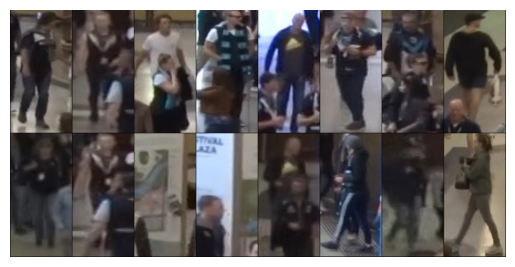

[0. 1. 1. 0. 1. 0. 0. 0.]


In [15]:
data_loader_vis= DataLoader(
    SNN_dataset(data, train_ix), batch_size=8, shuffle=True, drop_last=True)
dataiter = iter(data_loader_vis)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [16]:
batch_size = 8

train_dataset = SNN_dataset(data, train_ix)
data_loader_train = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = SNN_dataset(data, test_ix)
data_loader_test = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


In [17]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self,  x1, x2, targets):

        d = torch.nn.functional.pairwise_distance(x1, x2)  # euclidean dist

        loss = (1-targets)*torch.pow(d, 2) + \
            targets * torch.pow(torch.clamp(self.margin - d, min=0.0), 2)
        loss = torch.mean(loss)

        return loss


In [18]:
snn_classifier = SNN_classifier().to(device)

In [19]:
# criterion = ContrastiveLoss() # this is for regression!
criterion = nn.BCELoss()
lr = 1e-3
optimizer = torch.optim.Adam(snn_classifier.parameters(),lr=lr,weight_decay=1e-5)

In [20]:
train_loss = []
valid_loss = []


In [29]:
start_epoch = 50
n_epochs = start_epoch+20

In [21]:
smart_mkdir('weights')

True

In [30]:
for epoch in range(start_epoch,n_epochs):

    epoch_train_loss = []
    snn_classifier.train()

    start = time.time()
    for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_train):

        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        optimizer.zero_grad()

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)
        loss = criterion(output, targets)
        loss.backward()
        epoch_train_loss.append(loss.item())
        optimizer.step()
    
    train_loss.append(sum(epoch_train_loss)/len(epoch_train_loss))
    writer.add_scalar('Loss/train', train_loss[-1], epoch)

    epoch_valid_loss = []
    snn_classifier.eval()

    for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_test):
        
        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)
        loss = criterion(output, targets)
        epoch_valid_loss.append(loss.item())
    
    valid_loss.append(sum(epoch_valid_loss)/len(epoch_valid_loss))
    writer.add_scalar('Loss/validation', valid_loss[-1], epoch)
    
    print(f"Epoch {epoch} in {time.time()-start}: train loss={train_loss[-1]}, valid loss={valid_loss[-1]}")

    if ((epoch+1) % 1) == 0:
        print("Saving model")
        torch.save(snn_classifier.state_dict(),
                   os.path.join('weights', f"model_{epoch+1}.pt"))
        print("----------------------------")

torch.save(snn_classifier.state_dict(),
           os.path.join('weights', 'model_final.pt'))


Epoch 50 in 755.364367723465: train loss=0.1417447898075712, valid loss=0.12537702055177563
Saving model
----------------------------
Epoch 51 in 772.27623295784: train loss=0.1334778080688753, valid loss=0.10979121660384353
Saving model
----------------------------
Epoch 52 in 774.8072454929352: train loss=0.1324414035137554, valid loss=0.11598023126861329
Saving model
----------------------------
Epoch 53 in 772.4335994720459: train loss=0.13478002624655827, valid loss=0.105213113079141
Saving model
----------------------------
Epoch 54 in 772.0663454532623: train loss=0.1282633156089866, valid loss=0.09922150205524341
Saving model
----------------------------
Epoch 55 in 771.5704793930054: train loss=0.1258810578678054, valid loss=0.11802548288139662
Saving model
----------------------------
Epoch 56 in 772.1102530956268: train loss=0.12159288636270243, valid loss=0.09524579269202822
Saving model
----------------------------
Epoch 57 in 772.7157051563263: train loss=0.11757692915018

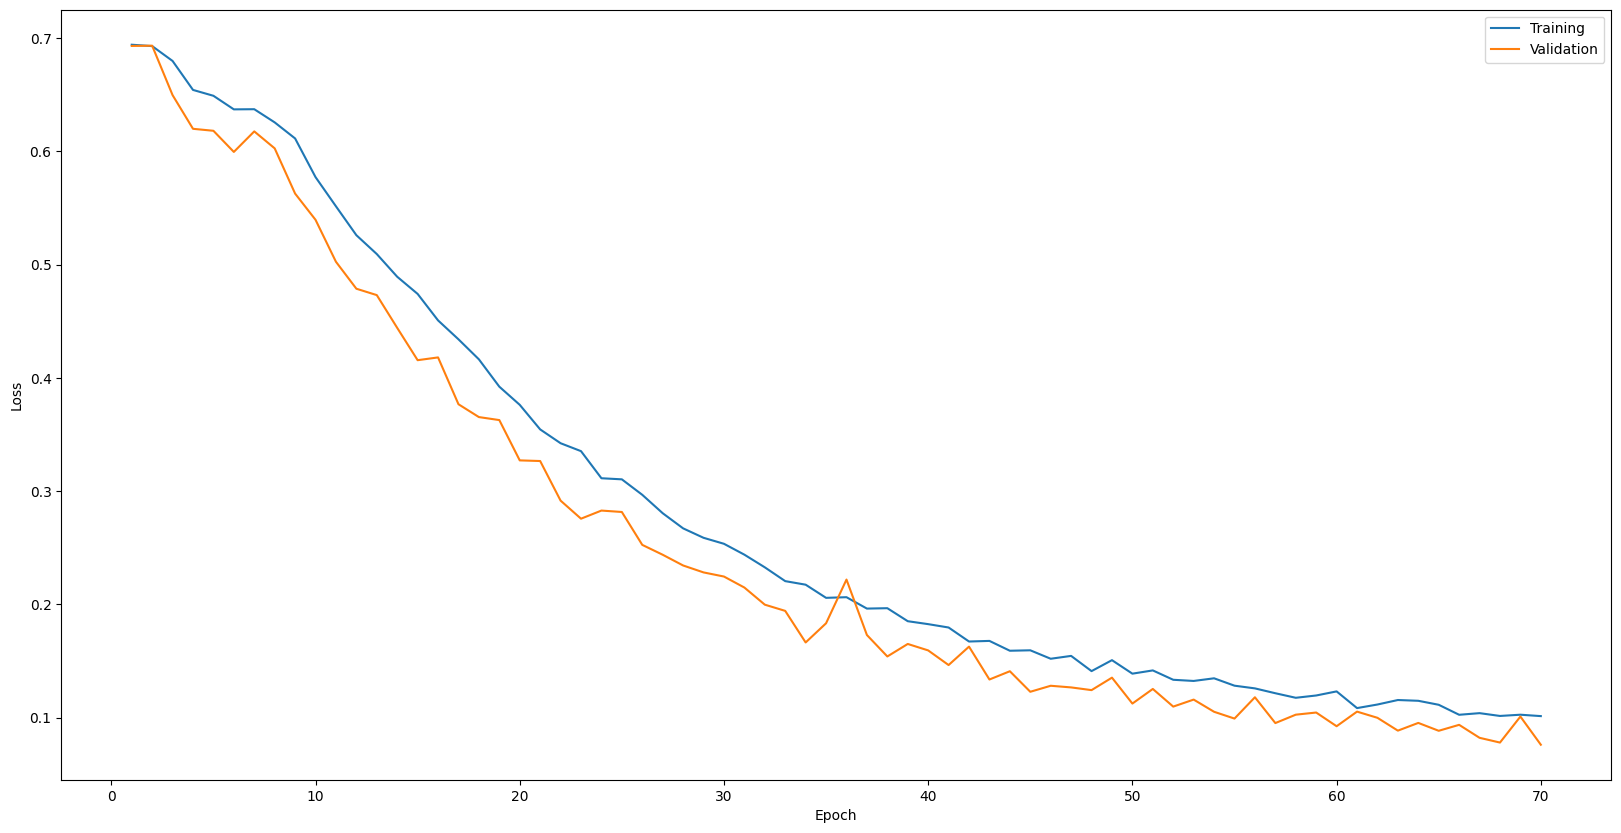

In [32]:
plt.figure(figsize=(20, 10))

train_l = len(train_loss)
valid_l = len(valid_loss)

plt.plot(np.linspace(1, train_l, train_l).astype(
    int), train_loss, label="Training")

plt.plot(np.linspace(1, valid_l, valid_l).astype(
    int), valid_loss, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.savefig(os.path.join("weights","training.png"))

## Test section

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [24]:
snn_classifier = SNN_classifier().to(device)

In [25]:
snn_classifier.load_state_dict(torch.load(os.path.join('weights','model_final.pt'), map_location=device))

<All keys matched successfully>

In [26]:
test_dir = os.path.join('..','data','test')

In [27]:
preprocess = transforms.Compose([
            transforms.Resize((512,256)),
            transforms.ToTensor()
        ])

In [28]:
riki1 = preprocess(Image.open(os.path.join(test_dir,'riki1.jpg'))).to(device).unsqueeze(0)
riki1_fv = snn_classifier.forward_resnet18(riki1)
riki2 = preprocess(Image.open(os.path.join(test_dir,'riki2.jpg'))).to(device).unsqueeze(0)
riki2_fv = snn_classifier.forward_resnet18(riki2)
riki3 = preprocess(Image.open(os.path.join(test_dir,'riki3.jpg'))).to(device).unsqueeze(0)
riki3_fv = snn_classifier.forward_resnet18(riki3)
ale1 = preprocess(Image.open(os.path.join(test_dir,'ale1.jpg'))).to(device).unsqueeze(0)
ale1_fv = snn_classifier.forward_resnet18(ale1)
anna1 = preprocess(Image.open(os.path.join(test_dir,'anna1.jpg'))).to(device).unsqueeze(0)
anna1_fv = snn_classifier.forward_resnet18(anna1)
anna2 = preprocess(Image.open(os.path.join(test_dir,'anna2.jpg'))).to(device).unsqueeze(0)
anna2_fv = snn_classifier.forward_resnet18(anna2)

In [29]:
%timeit snn_classifier(riki1,anna1_fv)

30.7 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
